In [1]:
%run "src\utils\notebook_style.ipynb"


In [2]:
# Symbole für Integration der Krümmung

f_ct, E_c, b, h, W_c, M_r, E_s, f_cc, f_c, f_s550= sp.symbols('f_ct, E_c, b, h, W_c, M_r E_s f_cc f_c f_s550')
A_i, A_c, A_s, s_x, diam_s = sp.symbols('A_i, A_c, A_s, s_x \\oslash_s')
chi_r, I_1 = sp.symbols('chi_r, I^I')
zeta_c, c_nom, I_2 = sp.symbols('zeta_c c_nom I^{II}')
chi_M = sp.Function('chi')(M)
sigma_c_inf_1, F_c1, z_1 = sp.symbols('sigma_c_inf\,1, F_c\,1 z_1')
z_2 = sp.symbols('F_c\,2 z_2')
F_z2, F_c2, f_sy, x_2, epsilon_s2, epsilon_c2, sigma_s2, chi_II, sigma_c_inf_2, M_2 = sp.symbols('F_z\,2 F_c\,2 f_sy x_2 varepsilon_s\,2 varepsilon_c\,2 sigma_s\,2 \chi^{II} sigma_c_inf\,2 M_2')
EI_II, EI_I = sp.symbols('EI^{II} EI^I')
epsilon_sy, x_3, F_c3, F_s3, chi_y, M_y, sigma_c_inf_3 = sp.symbols('varepsilon_sy x_3 F_c\,3, F_s\,3, \chi_y M_y sigma_c_inf\,3')
x_4, M_R, epsilon_cu, epsilon_s4,epsilon_su, chi_u = sp.symbols('x_4 M_R varepsilon_cu varepsilon_s\,4 varepsilon_su chi_u')
EI_III = sp.symbols('EI^{III}')
w_1 = sp.symbols('w_1')
f_su = sp.symbols('f_su')

epsilon_s, epsilon_c = sp.symbols('varepsilon_s varepsilon_c')
sigma_epsilon_s = sp.Function('sigma_s')(epsilon_s)
sigma_epsilon_c = sp.Function('sigma_c')(epsilon_c)

In [3]:
params_krummung = {
    f_ct:4.*unit.N / unit.mm**2,
    E_c:30000.*unit.N / unit.mm**2,
    f_c:35.*unit.N/unit.mm**2,
    E_s:200000.*unit.N / unit.mm**2,
    diam_s:18.*unit.mm,
    c_nom:20.*unit.mm,
    f_sy:670.*unit.N/unit.mm**2,
    f_s550:550.*unit.N/unit.mm**2,
    f_su:800*unit.N/unit.mm**2,
    epsilon_cu : 3/1000,
    epsilon_su : 50/100,
}

params_zustandslinien = {
    b:170.*unit.mm, # Breite des Trägers
    h:450.*unit.mm, # Höhe des Trägers,

}



In [4]:
Laststufen = np.linspace(1,320*10**3,100)
params = dict(params_krummung)
params.update(params_zustandslinien)

params_plot = param_value(params)
Eq_list = []

# Verformung an einem einfachen Balken

## Numerische Integration der Krümmung


### Grundlagen

Um sich von der Betrachtung einer konstanten Biegesteifigkeit zu lösen, hilft die Anwendung einer verfeinerten Momenten-Krümmungsbeziehung. Folgend wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_a3.


![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch_A3.svg){#fig-qs_a3}


Vereinfacht wird der Querschnitt folgender massen:


![Vereinfachung der Bewehrungsführung](../images/QS_analyse_1.svg){#fig_qs_1}

Die Parameter in @tbl-params_krummung finden Einfluss in die Berechnungen.

In [5]:
#| label: tbl-params_krummung
#| tbl-cap: Versuchsparameter für die verfeinerte Momenten-Krümmungsbeziehung


dict_to_table(params_krummung)

|   |   |
|---|---|
| $E_{c} = 30000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $E_{s} = 200000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $\oslash_{s} = 18.0 \, \text{mm}$ | $c_{nom} = 20.0 \, \text{mm}$ |
| $f_{c} = 35.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{ct} = 4.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{s550} = 550.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{su} = 800 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{sy} = 670.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $\varepsilon_{cu} = 0.003$ |
| $\varepsilon_{su} = 0.5$ | |


Neben den Parametern wird das Stoffgesetz für den Betonstahl in @fig-stahlkennlinie hinterlegt. Das Bilineare, bzw. linear-elastisch linear-plastische Spannungs-Dehnungsdiagramm für den Betonstahl hält den Rechenaufwand klein und liefert eine ausreichende Genauigkeit. Eine Berücksichtigung des verfestigenden Verhaltens ist essentiell um die Verformungen nach dem Fliessen des Betonstahls näherungsweise zu bestimmen. Das Diagramm ist definiert bis zur Bruchdehnung des Stahls. Das Verhalten gilt ebenso im negativen Spannungs-Dehnungs Bereich.

In [6]:
eq_1 = sp.Eq(f_sy, a +b*f_sy/E_s)
eq_2 = sp.Eq(f_su, a + b*epsilon_su)



eq_lin = sp.Eq(sigma_epsilon_s, a + b * epsilon_s).subs(sp.solve([eq_1,eq_2],[a,b]))

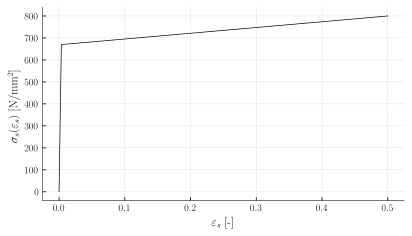

In [7]:
#| label: fig-stahlkennlinie
#| fig-cap: Spannungs-Dehnungs Diagramm des Bewehrungsstahls linear elastisch-linear verfestigend plastisch


eq_sigma_epsilon_s = sp.Eq(sigma_epsilon_s, sp.Piecewise(
    (E_s * epsilon_s, (epsilon_s<=f_sy / E_s)&(epsilon_s>=0)),
    (eq_lin.rhs.subs(params_plot), (epsilon_s<=epsilon_su)&(epsilon_s>=f_sy / E_s))
    ))




eq_sigma_epsilon_s_num = eq_sigma_epsilon_s.subs(params_plot) 

eq_sigma_epsilon_s_lamb = sp.lambdify((epsilon_s),eq_sigma_epsilon_s_num.rhs)


epsilon_s_array = np.linspace(0, np.float64(epsilon_su.subs(params_plot)), 2000)
eq_sigma_epsilon_array = eq_sigma_epsilon_s_lamb(epsilon_s_array)


plt.plot(epsilon_s_array, eq_sigma_epsilon_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_s)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_s)}$ [N/mm$ ^2$]')
plt.savefig('../images/spannung_dehnung_stahl.svg')

plt.show()

In [8]:
eq_sigma_epsilon_c = sp.Eq(sigma_epsilon_c,sp.Piecewise((E_c * epsilon_c, (epsilon_c <=f_ct/E_c)&(epsilon_c >-f_c/E_c)), (-f_c, epsilon_c< -f_c/E_c)))


eq_sigma_epsilon_c_num = eq_sigma_epsilon_c.subs(params_plot)



Die Betonkennlinie in @fig-betonkennlinie zeigt ein linear-elastisches ideal-plastisches verhalten. Im positiven Bereich lässt sich die Betonspannung bis zur Betonzugfestigkeit erhöhen, im negativen Spannungsbereich beginnt ein Plastifizieren beim Erreichen der Betondruckfestigkeit. Bis zur Bruchstauchung ist dies definiert.

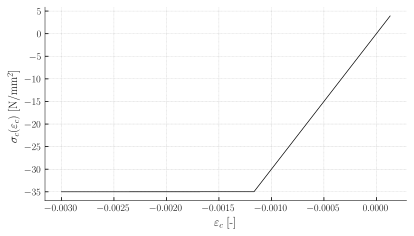

In [9]:
#| label: fig-betonkennlinie
#| fig-cap: Spannungs-Dehnungs Diagramm des Betons linear elastisch-ideal plastisch


eq_sigma_epsilon_c_lamb = sp.lambdify((epsilon_c),eq_sigma_epsilon_c_num.rhs)


epsilon_c_array = np.linspace(-np.float64(epsilon_cu.subs(params_plot)), np.float64(epsilon_cu.subs(params_plot)), 2000)
eq_sigma_epsilon_c_array = eq_sigma_epsilon_c_lamb(epsilon_c_array)


plt.plot(epsilon_c_array, eq_sigma_epsilon_c_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_c)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_c)}$ [N/mm$ ^2$]')
plt.savefig('../images/spannung_dehnung_beton.svg')

plt.show()

### Querschnittsanalyse

Mittels einer Querschnittsanalyse lassen sich die unterschiedlichen Zustände des Momenten-Krümmungdiagramms ermitteln.

#### Schwerpunkt des Querschnitts

Durch die Bestimmung der Wertigkeit $n$ kann der Querschnitt als homogener Betonquerschnitt zur Bestimmung des Schwerpunkts behandelt werden.

In [10]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
Eq_list.append(eq_n_num)



display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 6.67

Die Querschnittsfläche der Bewehrung beträgt:

In [11]:
eq_A_s = sp.Eq(A_s, sp.Mul(2,sp.pi * diam_s **2 / (4), evaluate=False)+sp.pi*(12*unit.mm)**2 / 4 *f_s550/f_sy)
eq_A_s_num = unit.convert_to(eq_A_s.subs(params), unit.mm)
Eq_list.append(eq_A_s_num)
display(eq_A_s, eq_A_s_num.evalf(4))



                          2                    
     36⋅π⋅fₛ₅₅₀⋅millimeter                    2
Aₛ = ────────────────────── + 2⋅1/4⋅π⋅\oslashₛ 
              f_sy                             

                     2
Aₛ = 601.8⋅millimeter 

Die Betonquerschnittsfläche:

In [12]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(eq_A_c.subs(params), unit.mm)

Eq_list.append(eq_A_c_num)

display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                        2
A_c = 76500.0⋅millimeter 

Die ideelle Querschnittsfläche resultiert zu:

In [13]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(eq_subs(eq_Ai, *Eq_list), unit.mm)

Eq_list.append(eq_Ai_num)

display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                       2
Aᵢ = 79910.1⋅millimeter 

Und die z-Koordinate des Schwerpunkts folgt abschliessend zu:

In [14]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(eq_subs(eq_zeta_c, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_zeta_c_num)
display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 217.0⋅millimeter

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Bewehrung sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [15]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(eq_subs(eq_I_1, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_I_1_num)
display(eq_I_1, eq_I_1_num.evalf(3))


                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 1.39e+9⋅millimeter 

#### Ungerissen - Zustand 1

Der Querschnitt verbleibt elastisch. Folglich kann das Flächenträgheitsmoment mit $E_c$ multipliziert werden und es resultiert die ungerissene Biegesteifigkeit:

In [16]:
eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = eq_subs(eq_EI_1, *Eq_list).subs(params)

Eq_list.append(eq_EI_I_num)


In [17]:

display(eq_EI_1, unit.convert_to(eq_EI_I_num.evalf(4),[unit.kilonewton, unit.meter]))

EI__I = E_c⋅I__I

                                 2
EI__I = 4.183e+4⋅kilonewton⋅meter 

##### Rissmoment

Durch die Ermittlung des Rissmoments kann die Krümmung vor dem Reissen des Betons ermittelt werden. Die Betonzugkraft wird nicht berücksichtigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_analyse_2.svg){#fig-qs2}


Die Betondruckspannung beträgt:

In [18]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_inf_1,f_ct / zeta_c * (h-zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(eq_subs(eq_sigma_c_inf1,*Eq_list).subs(params),unit.mm)

Eq_list.append(eq_sigma_c_inf1_num)
display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))


            f_ct⋅(h - ζ_c)
σ_c_inf,1 = ──────────────
                 ζ_c      

            4.28⋅newton
σ_c_inf,1 = ───────────
                      2
            millimeter 

Der Hebelarm der inneren Kräfte folgt zu:

In [19]:
eq_z_r = sp.Eq(z_1, h - ((h-zeta_c)/3 + c_nom + 3/2 * diam_s))
eq_z_r_num = unit.convert_to(eq_subs(eq_z_r, *Eq_list).subs(params), unit.mm)
Eq_list.append(eq_z_r_num)
display(eq_z_r, eq_z_r_num.evalf(3))

                            2⋅h   ζ_c
z₁ = -1.5⋅\oslashₛ - cₙₒₘ + ─── + ───
                             3     3 

z₁ = 326.0⋅millimeter

Die Betondruckkraft ist definiert nach:

In [20]:
eq_F_c_r = sp.Eq(F_c1,  sigma_c_inf_1 * b * (h-zeta_c)/2)
eq_F_c_r_num = eq_subs(eq_F_c_r, *Eq_list).subs(params)

Eq_list.append(eq_F_c_r_num)
display(eq_F_c_r, unit.convert_to(eq_F_c_r_num.evalf(3), unit.kilonewton))


        b⋅σ_c_inf,1⋅(h - ζ_c)
F_c,1 = ─────────────────────
                  2          

F_c,1 = 84.6⋅kilonewton

Und das Rissmoment resultiert schliesslich zu:

In [21]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = eq_subs(eq_M_r, *Eq_list)
Eq_list.append(eq_M_r_num)


In [22]:

display(eq_M_r, unit.convert_to(eq_M_r_num.evalf(4), [unit.kilonewton, unit.meter]))

Mᵣ = F_c,1⋅z₁

Mᵣ = 27.54⋅kilonewton⋅meter

Aus dem Rissmoment folgt die Krümmung beim Reissen:

In [23]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(eq_subs(eq_chi_r, *Eq_list), unit.m)

Eq_list.append(eq_chi_r_num)
display(eq_chi_r,eq_chi_r_num.evalf(3))

       Mᵣ 
χᵣ = ─────
     EI__I

     0.000659
χᵣ = ────────
      meter  

Die Neigung linearen Funktion des ungerissenen Zustands im Momentenkrümmungsdiagramm ist durch die Biegesteifigkeit definiert. Der Endpunkts des Zustand 1 definiert das Rissmoment mit der entsprechenden Krümmung.

#### Gerissen Elastisch - Zustand 2

Der Querschnitt nach dem Reissen ist in @fig-qs3 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton die Druckfestigkeit ebenfalls nicht.

![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_analyse_3.svg){#fig-qs3}

Dabei beträgt die statische Höhe:

In [24]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = eq_d.subs(params)
Eq_list.append(eq_d_num)

display(eq_d, eq_d_num)

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 403.0⋅millimeter

Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe und folglich die gerissene Biegesteifigkeit herleiten. Die Betonstahlzugkraft beträgt:




In [25]:
eq_F_z2 = sp.Eq(F_z2, sigma_s2*A_s)
Eq_list.append(eq_F_z2)
display(eq_F_z2)


F_z,2 = Aₛ⋅σ_s,2

Die Betonstahlspannung für linear elastisches Verhalten folgt zu:

In [26]:
eq_sigma_s2 = sp.Eq(sigma_s2, epsilon_s2 * E_s)
Eq_list.append(eq_sigma_s2)
eq_sigma_s2

σ_s,2 = Eₛ⋅varepsilon_s,2

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3 beträgt:


In [27]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_inf_2 * b * x_2 /2)
Eq_list.append(eq_F_c2)
eq_F_c2


        b⋅σ_c_inf,2⋅x₂
F_c,2 = ──────────────
              2       

Die Betonspannung ebenfalls bestimmt durch ein linear elastisches Verhalten ist definiert durch:

In [28]:
eq_sigma_c_inf2 = sp.Eq(sigma_c_inf_2, epsilon_c2* E_c)
Eq_list.append(eq_sigma_c_inf2)
eq_sigma_c_inf2

σ_c_inf,2 = E_c⋅varepsilon_c,2

Die Betondehnung anhand des Dehnungsverlaufs in @fig-qs3:

In [29]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s2 /(d-x_2) * x_2)
Eq_list.append(eq_epsilon_c2)
eq_epsilon_c2

                 varepsilon_s,2⋅x₂
varepsilon_c,2 = ─────────────────
                       d - x₂     

Unter Bemühung des Gleichgewichts der horizontalen Kräfte lässt sich die folgende Beziehung ermitteln.

In [30]:
eq_ggw_1 = sp.Eq(F_c2, F_z2)
Eq_list.append(eq_ggw_1)
eq_ggw_1

F_c,2 = F_z,2

Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung und mit $n$ und $\rho$ substituiert, folgt:

In [31]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
Eq_list.append(eq_n_num)

eq_rho = sp.Eq(rho, A_s/(b*d))
Eq_list.append(eq_rho)


display(eq_n, eq_rho)

     Eₛ
n = ───
    E_c

     Aₛ
ρ = ───
    b⋅d

In [32]:
eq_ggw_1_subs = eq_subs(eq_F_c2,eq_sigma_c_inf2, eq_epsilon_c2, eq_ggw_1, eq_F_z2).subs(E_c, E_s/n).subs(sigma_s2, epsilon_s2 * E_s).subs(A_s, rho*b*d).simplify()
eq_ggw_1_subs

                                                2
                          Eₛ⋅b⋅varepsilon_s,2⋅x₂ 
Eₛ⋅b⋅d⋅ρ⋅varepsilon_s,2 = ───────────────────────
                                2⋅n⋅(d - x₂)     

Durch die Auflösung nach $x$ folgt die Betondruckzonenhöhe:

In [33]:
eq_x_2 = sp.Eq(x_2,sp.solve(eq_ggw_1_subs, x_2)[0])
eq_x_2_num = unit.convert_to(eq_subs(eq_x_2, *Eq_list).subs(params),unit.mm)
Eq_list.append(eq_x_2)
display(eq_x_2, eq_x_2_num.evalf(3))

       ⎛         _______________⎞
x₂ = d⋅⎝-n⋅ρ + ╲╱ n⋅ρ⋅(n⋅ρ + 2) ⎠

x₂ = 116.0⋅millimeter

Zur Bestimmung der Krümmung ist die Betonstahldehnung erforderlich. Diese bedingt ein einwirkendes Moment. Der Übergang zwischen ungerissenem zu gerissenem Verhalten erfolgt beim Rissmoment. Folglich kann das Rissmoment in @fig-qs3 angesetzt werden.

In [34]:
eq_M_2 = sp.Eq(M_2, F_z2 * (d-x_2/3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

display(eq_M_2,eq_M_2_M_r, eq_subs(eq_M_2,eq_M_2_M_r, eq_F_z2, eq_sigma_s2))

           ⎛    x₂⎞
M₂ = F_z,2⋅⎜d - ──⎟
           ⎝    3 ⎠

M₂ = Mᵣ

                          ⎛    x₂⎞
Mᵣ = Aₛ⋅Eₛ⋅varepsilon_s,2⋅⎜d - ──⎟
                          ⎝    3 ⎠

Daraus resultiert die Betonstahldehnung:

In [35]:
eq_epsilon_s2 = sp.Eq(epsilon_s2,sp.solve(eq_subs(eq_M_2, eq_x_2, eq_sigma_s2, eq_F_z2, eq_M_2_M_r), epsilon_s2)[0])

eq_epsilon_s2_num = eq_subs(eq_epsilon_s2, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_s2_num)


display(eq_epsilon_s2_num.evalf(3))

varepsilon_s,2 = 0.000628

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3 bestimmt werden:

In [36]:
eq_chi_II = sp.Eq(chi_II, epsilon_s2/(d-x_2))
eq_chi_II_num = unit.convert_to(eq_subs(eq_chi_II, eq_x_2_num, eq_d_num, eq_epsilon_s2_num).simplify(), unit.m)
Eq_list.append(eq_chi_II)

display(eq_chi_II,eq_chi_II_num.evalf(3))


             varepsilon_s,2
\chi__{II} = ──────────────
                 d - x₂    

             0.00219
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [37]:

eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()
Eq_list.append(eq_EI_II_num)


In [38]:
display(eq_EI_II, unit.convert_to(eq_EI_II_num.evalf(6), [unit.kilonewton, unit.meter]))



               M₂    
EI__{II} = ──────────
           \chi__{II}

                                   2
EI__{II} = 12567.0⋅kilonewton⋅meter 

Die Neigung der linearen Funktion im gerissenen Bereich ist durch die gerissene Biegesteifigkeit definiert. Der Beginn ist durch das Rissmoment definiert.

#### Fliessen der Bewehrung - Zustand 3

Die Biegesteifigkeit $EI^{II}$ gilt bis die Bewehrung fliesst oder der Beton beginnt zu plastifizieren. In @fig-qs4 wird vorausgesetzt, dass die Bewehrung fliesst.

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung](../images/QS_analyse_4.svg){#fig-qs4}

Durch Gleichgewicht der horizontalen Kräfte folgen die Beziehungen:

In [39]:
eq_sigma_c_inf3 = sp.Eq(sigma_c_inf_3,f_sy / E_s / (d-x_3) *x_3 * E_c)
eq_ggw_fliessen = sp.Eq(A_s * f_sy, x_3 * b * sigma_c_inf_3/2)
display(eq_sigma_c_inf3,eq_ggw_fliessen)

            E_c⋅f_sy⋅x₃
σ_c_inf,3 = ───────────
            Eₛ⋅(d - x₃)

          b⋅σ_c_inf,3⋅x₃
Aₛ⋅f_sy = ──────────────
                2       

Aufgelöst nach der Druckzonenhöhe:

In [40]:
eq_x_3 = sp.Eq(x_3,sp.solve(eq_subs(eq_ggw_fliessen, eq_sigma_c_inf3), x_3)[1])
eq_x_3_num = unit.convert_to(eq_subs(eq_x_3, *Eq_list).subs(params), unit.mm).simplify()
Eq_list.append(eq_x_3)

display(eq_x_3, eq_x_3_num.evalf(3))

                ___________________________
     -Aₛ⋅Eₛ + ╲╱ Aₛ⋅Eₛ⋅(Aₛ⋅Eₛ + 2⋅E_c⋅b⋅d) 
x₃ = ──────────────────────────────────────
                     E_c⋅b                 

x₃ = 116.0⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungsdiagramm für den gerissenen Zustand definiert:

In [41]:
eq_M_y = sp.Eq(M_y, A_s * f_sy * (d-x_3/3))
eq_M_y_num =  eq_subs(eq_M_y, *Eq_list).subs(params).simplify()
display(eq_M_y, unit.convert_to(eq_M_y_num.evalf(4), [unit.kilonewton, unit.meter]))

              ⎛    x₃⎞
M_y = Aₛ⋅f_sy⋅⎜d - ──⎟
              ⎝    3 ⎠

M_y = 146.9⋅kilonewton⋅meter

Die Fliessdehnung des Betonstahls entspricht:

In [42]:
eq_epsilon_sy = sp.Eq(epsilon_sy, f_sy / E_s)

Eq_list.append(eq_epsilon_sy)

eq_epsilon_sy.subs(params)

varepsilon_sy = 0.00335

Abschliessend lässt sich die Krümmung für den Endpunkt des Zustands 2 folgend bestimmen:

In [43]:
eq_chi_y = sp.Eq(chi_y, epsilon_sy / (d-x_3))


In [44]:

eq_chi_y_num = eq_subs(eq_chi_y, *Eq_list).subs(params).simplify()
Eq_list.append(eq_chi_y_num)
display(eq_chi_y, unit.convert_to(eq_chi_y_num.evalf(3), unit.meter))

         varepsilon_sy
\chi_y = ─────────────
             d - x₃   

         0.0117
\chi_y = ──────
         meter 

Der Zustand 3 beschreibt lediglich den Endpunkt des gerissenen Bereichs im Momenten-Krümmungsdiagramm.

#### Maximaler Biegewiderstand - Zustand 4

Abschliessen kann der maximale Biegewiderstand durch die plastifizierung der Betondruckzone bestimmt werden. Vereinfacht wird dem Betonstahl die statische Zugfestigkeit vorausgesetzt um das verfestigende Verhalten annähernd abzubilden. Dies bedingt grundsätzlich das Erreichen der Bruchdehnung im Stahl. Da der Querschnitt stark bewehrt ist, versagt die Betondruckzone vor dem Erreichen der Betonstahlbruchdehnung.

![Querschnittsanalyse für reine Biegung mit der Bewehrung bei der Bruchspannung und plastifizierter Betondruckzone](../images/QS_analyse_5.svg){#fig-qs5}

Vereinfacht werden die Spannungen in der Druckzone konstant verteilt betrachtet. Dazu wird die Druckzonenhöhe abgemindert um Faktor 0.85.

Das Gleichgewicht der Kräfte führt zu:

In [45]:
eq_ggw_R = sp.Eq(A_s * f_su, sp.Mul(0.85,x_4 * b * f_c, evaluate=False))

display(eq_ggw_R)

Aₛ⋅fₛᵤ = 0.85⋅b⋅f_c⋅x₄

Die Druckzonenhöhe folgt zu:

In [46]:
eq_x_4 = sp.Eq(x_4, sp.solve(eq_ggw_R, x_4)[0])
eq_x_4_num = unit.convert_to(eq_subs(eq_x_4, *Eq_list).subs(params),unit.mm)

Eq_list.append(eq_x_4_num)
display(eq_x_4_num.evalf(3))

x₄ = 95.2⋅millimeter

Der maximale Biegewiderstand folgt zu:

In [47]:
eq_M_R = sp.Eq(M_R, A_s * f_su * (d-0.85*x_4/2))
eq_M_R_num = unit.convert_to(eq_subs(eq_M_R, *Eq_list).subs(params),unit.m)

Eq_list.append(eq_M_R_num)
display(eq_M_R, unit.convert_to(eq_M_R_num.evalf(4), unit.kilonewton))

M_R = Aₛ⋅fₛᵤ⋅(d - 0.425⋅x₄)

M_R = 174.5⋅kilonewton⋅meter

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [48]:
eq_chi_u = sp.Eq(chi_u, epsilon_cu / x_4)
eq_chi_u_num = eq_subs(eq_chi_u, *Eq_list).subs(params)

Eq_list.append(eq_chi_u_num)

display(eq_chi_u, unit.convert_to(eq_chi_u_num.evalf(3), unit.meter))

     varepsilon_cu
χᵤ = ─────────────
           x₄     

     0.0315
χᵤ = ──────
     meter 

Die Betonstahldehnung darf die Bruchdehnung nicht überschreiten:

In [49]:
eq_epsilon_s4 = sp.Eq(epsilon_s4, epsilon_cu / x_4 * (d-x_4))
eq_epsilon_su_num = eq_subs(eq_epsilon_s4, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_su_num)
display(eq_epsilon_s4, eq_epsilon_su_num.evalf(3))

                 varepsilon_cu⋅(d - x₄)
varepsilon_s,4 = ──────────────────────
                           x₄          

varepsilon_s,4 = 0.0097

Die Bruchdehnung des Stahls wird nicht erreicht. Der Querschnitt versagt im Druckbereich. Die Annahme, dem Betonstahl die statische Zugfestigkeit zu Grunde zu legen ist grundsätzlich nicht gerechtfertig. Der Vergleich mit den Versuchsergebnissen zeigt jedoch, dass sich diese Annahme bewährt.

In [50]:
eq_epsilon_sw = sp.Eq(epsilon_su,params[epsilon_su])
eq_epsilon_sw

varepsilonₛᵤ = 0.5

Die Biegesteifigkeit im Bereich 3 beträgt:

In [51]:
eq_EI_III = sp.Eq(EI_III, (M_R)/(chi_u))
eq_EI_III_num = eq_subs(eq_EI_III, *Eq_list).simplify()
display(eq_EI_III, unit.convert_to(eq_EI_III_num.evalf(3), [unit.kilonewton, unit.meter]))

            M_R
EI__{III} = ───
             χᵤ

                                    2
EI__{III} = 5.54e+3⋅kilonewton⋅meter 

In [52]:
eq_1 = sp.Eq(chi_y, r + m*-M_y)
eq_2 = sp.Eq(chi_u, r + m*-M_R)


eq_solve = sp.solve([eq_1,eq_2],[r,m])

m_solve = eq_solve[m].subs(chi_u, -M_R/EI_III).subs(chi_y,-M_y / EI_II)
r_solve = eq_solve[r].subs(chi_u, -M_R/EI_III).subs(chi_y,-M_y / EI_II)

chi_M_linear = sp.Eq(chi_M,r_solve + m_solve * M)


Der Zustand 4 beschreibt den Endpunkt des Momenten-Krümmungsdiagramm.

#### Momenten-Krümmungsdiagramm

Abschliessend lässt sich aus der Querschnittsanalyse die Beziehung zwischen Biegemoment und Krümmung ermitteln. Der lineare verlauf im ersten Bereich ergibt sich aus der ungerissenen Biegesteifigkeit. Darauf folgt ein schlagartiger wechsel der Steifigkeit von $EI^I$ zu $EI^{II}$, da der Beton reisst. Dies führt zum Plateau im unteren Bereich. Im Bereich drei werden die zwei definierten Punkte $M_y, \chi_y$ sowie $M_R, \chi_u$ linear verbunden.

In [53]:
eq_chi_M = sp.Eq(chi_M, sp.Piecewise((0,M>=0),(M/ (EI_I), (M < 0) & (M > -eq_M_r.lhs)), (M/(EI_II), (M < -eq_M_r.lhs) & (M > -M_y)), (chi_M_linear.rhs , (M < -M_y) & (M > -M_R))))


In [54]:
M_chi_params = [
                eq_EI_I_num.rhs,
                eq_EI_II_num.rhs,
                eq_EI_III_num.rhs,
                eq_M_r_num.rhs,
                eq_M_y_num.rhs,
                eq_M_R_num.rhs
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


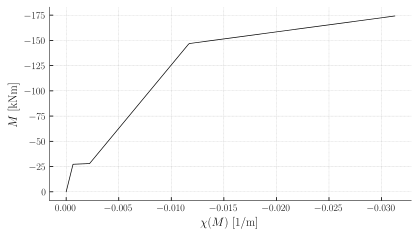

In [55]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich
M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)

chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)

M_array = np.linspace(0,-M_R_num * 2, 500)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)

plt.plot(chi_M_array, M_array/1000, color='black')

# Anmerkungen hinzufügen


plt.annotate('$EI^I$', xy=(0.0009, 15000), xytext=(0, -10), textcoords='offset pixels')
plt.annotate("$EI^{II}$", xy=(0.01, 50000), xytext=(10, 10), textcoords='offset pixels')

plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.savefig('../images/momenten_krummung_tue.svg')


plt.show()


In [56]:
from src.models.FEM import MomentenKruemmung, Schnittkraefte
import os

path_fem = 'src/models/data/Cubus_Versuch_Tue14.xlsx'


In [57]:
377*0.87/2/0.632

259.4857594936709

## Numerische Integration der Krümmungen

Zur Näherung an die Praxisanwendung ist die Momenten-Krümmungsbeziehung mittels einer FEM-Software ermittelt worden.

In [58]:
1132*0.632

715.424

In [59]:
print(os.getcwd())

c:\Users\Pascal Gitz\OneDrive - Hochschule Luzern\02_Master\03_Tragverhalten_von_Stahlbetontragwerken\docs


In [60]:
maximallast = Schnittkraefte(path_fem, 1000, 'Schnittkraefte')
fiktiv = Schnittkraefte(path_fem, 1000, 'fiktiv_mitte')

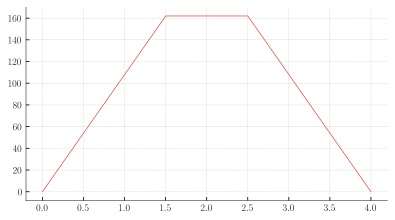

In [61]:
plt.plot(maximallast.x, maximallast.My)

In [62]:
qs_170_450 = MomentenKruemmung(path=path_fem,
                               n=1000)

In [63]:
qs_170_450.chi_y.to(1/un.meter)

<Quantity [0.00000000e+00, 5.01501502e-05, 1.00300300e-04, 1.50450450e-04,
           2.00600601e-04, 2.50750751e-04, 3.00900901e-04, 3.51051051e-04,
           4.01201201e-04, 4.51351351e-04, 5.01501502e-04, 5.51651652e-04,
           6.01801802e-04, 6.51951952e-04, 7.02102102e-04, 7.52252252e-04,
           8.02402402e-04, 8.52552553e-04, 9.02702703e-04, 9.52852853e-04,
           1.00300300e-03, 1.05315315e-03, 1.10330330e-03, 1.15345345e-03,
           1.20360360e-03, 1.25375375e-03, 1.30390390e-03, 1.35405405e-03,
           1.40420420e-03, 1.45435435e-03, 1.50450450e-03, 1.55465465e-03,
           1.60480480e-03, 1.65495495e-03, 1.70510511e-03, 1.75525526e-03,
           1.80540541e-03, 1.85555556e-03, 1.90570571e-03, 1.95585586e-03,
           2.00600601e-03, 2.05615616e-03, 2.10630631e-03, 2.15645646e-03,
           2.20660661e-03, 2.25675676e-03, 2.30690691e-03, 2.35705706e-03,
           2.40720721e-03, 2.45735736e-03, 2.50750751e-03, 2.55765766e-03,
           2.60780781e-03

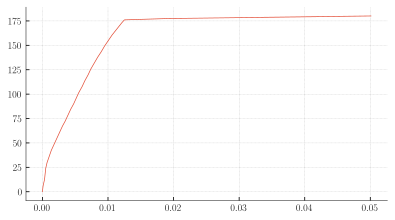

In [64]:
plt.plot(qs_170_450.chi_y.to(1/un.meter).value, qs_170_450.My.value)

In [65]:
qs_170_450.kruemmungsverlauf(maximallast.My)

array([0.00000000e+00, 7.32936326e-03, 1.46587265e-02, 2.19880898e-02,
       2.93174530e-02, 3.66468163e-02, 4.39761796e-02, 5.13089535e-02,
       5.86599527e-02, 6.60109519e-02, 7.33619511e-02, 8.07129503e-02,
       8.80639495e-02, 9.54149487e-02, 1.05135135e-01, 1.19549550e-01,
       1.33963964e-01, 1.48378378e-01, 1.62792793e-01, 1.77207207e-01,
       1.91621622e-01, 2.06036036e-01, 2.20450450e-01, 2.34864865e-01,
       2.49279279e-01, 2.63563267e-01, 2.77832426e-01, 2.92101586e-01,
       3.04427832e-01, 3.13628522e-01, 3.22829212e-01, 3.32029902e-01,
       3.41230592e-01, 3.50431282e-01, 3.56712281e-01, 3.62782401e-01,
       3.68852521e-01, 3.74922641e-01, 3.80992760e-01, 3.87062880e-01,
       3.93133000e-01, 3.99203120e-01, 4.06036036e-01, 4.13243243e-01,
       4.20450450e-01, 4.27657658e-01, 4.34864865e-01, 4.42072072e-01,
       4.49279279e-01, 4.56565849e-01, 4.63884442e-01, 4.71203035e-01,
       4.78521628e-01, 4.85840221e-01, 4.93158814e-01, 5.00477407e-01,
      

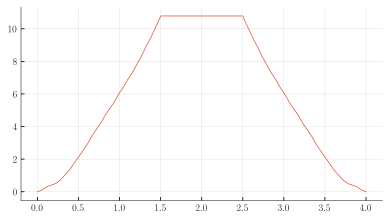

In [66]:
plt.plot(maximallast.x, qs_170_450.kruemmungsverlauf(maximallast.My))

In [67]:
np.trapz(qs_170_450.kruemmungsverlauf(maximallast.My)*fiktiv.My/un.kilonewton)

<Quantity 4.10878542 m>